In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import IPython.display as ipd
import h5py
import scipy.signal
import re
import cv2
import scipy.io
import subprocess
import glob
import matlab.engine
import io

In [6]:
data_path = '../data/raw/b151/211103_29837'
extracted_ephys_path = os.path.join(data_path,'ephys', 'logger_13', 'extracted_data')
cameras_path = os.path.join(data_path, 'cameras')
motu_path = os.path.join(data_path, 'motu')

# Preprocess

In [7]:
eng = matlab.engine.start_matlab()
out = io.StringIO()
err = io.StringIO()

In [8]:
LoggerDataProcessing = eng.genpath('../utils/LoggerDataProcessing')
data_path = eng.genpath('../data')
eng.addpath(LoggerDataProcessing, nargout=0)
eng.addpath(data_path, nargout=0)

In [10]:
eng.extract_logger_data('raw/b151/211105_29837/ephys/logger_13',nargout=0,stdout=out, stderr=err)

MatlabExecutionError: 
  File C:\Users\kevinqi\Desktop\HumanBat\utils\LoggerDataProcessing\extract_logger_data.m, line 371, in extract_logger_data
Index exceeds the number of array elements. Index must not exceed 0.


In [19]:
err.getvalue()

''

# MOTU data

In [291]:
motu_data = []
num_files = len(os.listdir(motu_path))
for i in range(num_files):
    data = np.load(os.path.join(motu_path,'audio_{}.npy'.format(i)))
    #data_ds = scipy.signal.decimate(data, 5)
    data_ds = data
    motu_data.append(data_ds)
    
motu_data = np.hstack(motu_data)

In [292]:
motu_data

array([[ 2.9174805e-02,  3.0090332e-02,  2.9846191e-02, ...,
         3.8391113e-02,  3.8116455e-02,  3.8269043e-02],
       [ 1.2207031e-04, -9.1552734e-05, -3.0517578e-05, ...,
        -3.0517578e-05,  2.4414062e-04, -1.2207031e-04],
       [-3.0517578e-05,  3.0517578e-05, -3.0517578e-05, ...,
        -2.0574951e-01, -2.0562744e-01, -2.0574951e-01],
       [-3.0517578e-05, -3.0517578e-05, -3.0517578e-05, ...,
         0.0000000e+00, -6.1035156e-05,  0.0000000e+00]], dtype=float32)

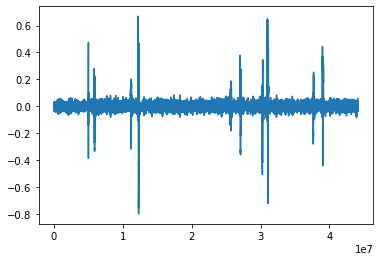

In [293]:
plt.plot(motu_data[0,:])

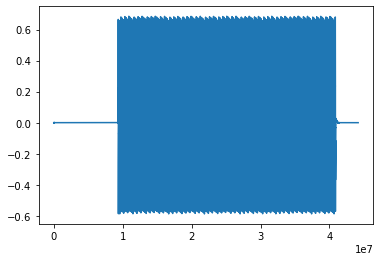

In [294]:
plt.plot(motu_data[1,:])

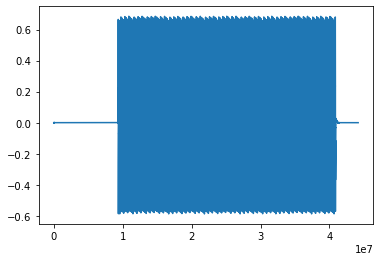

In [295]:
plt.plot(motu_data[1,:])

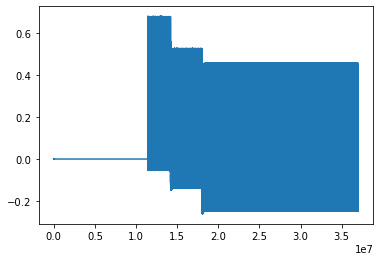

In [296]:
plt.plot(motu_data[2,3000000:40000000])

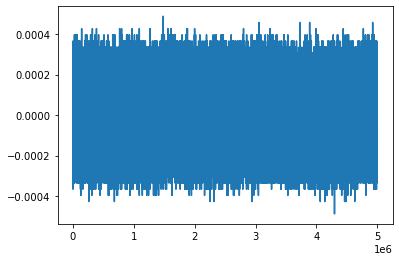

In [297]:
plt.plot(motu_data[1,:5000000])

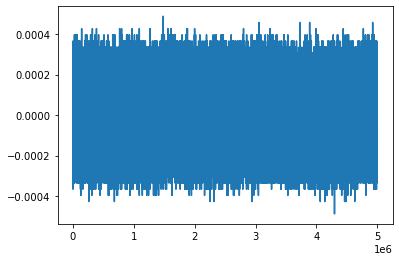

In [298]:
plt.plot(motu_data[1,:5000000])

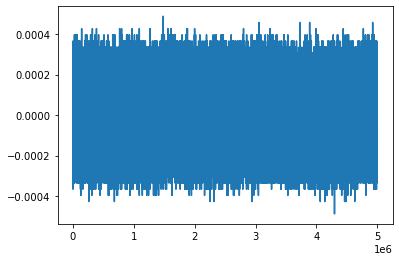

In [299]:
peak_x = np.array(scipy.signal.find_peaks(motu_data[1, :5000000],distance=132000, height=0.5)[0],dtype=np.uint64)
plt.plot(motu_data[1,:5000000])
plt.scatter(peak_x, motu_data[1,:5000000][peak_x])

In [300]:
def motu_ttl_indices(ttl_channel):
    peak_x = np.array(scipy.signal.find_peaks(ttl_channel,distance=132000, height=0.5)[0],dtype=np.uint64)
    return peak_x

In [301]:
motu_ttl_indices = motu_ttl_indices(motu_data[1,:])

In [405]:
motu_first_ttl_index = motu_ttl_indices[0]
motu_last_ttl_index = motu_ttl_indices[-1]

In [406]:
motu_ttl_ts_ms = (motu_ttl_indices - motu_first_ttl_index)/192

In [407]:
motu_ttl_ts_ms

array([     0.        ,    999.91666667,   1999.859375  ,   2999.80208333,
         3999.72395833,   4999.65104167,   5999.58854167,   6999.51041667,
         7999.44270833,   8999.36458333,   9999.29166667,  10999.23958333,
        11999.1875    ,  12999.09895833,  13999.03125   ,  14998.953125  ,
        15998.88020833,  16998.82291667,  17998.75      ,  18998.68229167,
        19998.61979167,  20998.55729167,  21998.46354167,  22998.41145833,
        23998.328125  ,  24998.27604167,  25998.203125  ,  26998.125     ,
        27998.05729167,  28997.99479167,  29997.92708333,  30997.85416667,
        31997.78645833,  32997.70833333,  33997.65625   ,  34997.58333333,
        35997.515625  ,  36997.44791667,  37997.375     ,  38997.29166667,
        39997.23958333,  40997.16666667,  41997.08854167,  42997.03125   ,
        43996.95833333,  44996.88020833,  45996.81770833,  46996.75      ,
        47996.66666667,  48996.59895833,  49996.54166667,  50996.50520833,
        51996.421875  ,  

# Experiment Log Data

In [305]:
os.listdir(data_path)

['cameras', 'ephys', 'motu', 'sync_test_211101_logs.txt']

In [306]:
arduino_ttl = []
state_name = []
arduino_state_ms = []
with open(os.path.join(data_path, 'sync_test_211101_logs.txt'), 'r') as f:
    for line in f.readlines():
        ttl_ts_matches= re.findall('(\d*)!', line) # Match ttl timestamps
        if(not ttl_ts_matches == []):
            arduino_ttl += ttl_ts_matches
        state_matches=re.search('(\w+)_ENTER:(\d+)|', line)
        if(state_matches.group(1) != None):
            state_name.append(state_matches.group(1))
            arduino_state_ms.append(state_matches.group(2))
arduino_ttl = np.array(arduino_ttl, dtype=np.uint64)
arduino_state_ms = np.array(arduino_state_ms, dtype=np.uint64)-arduino_ttl[0]
arduino_ttl = arduino_ttl - arduino_ttl[0]

In [307]:
arduino_ttl

array([     0,   1000,   2000,   3001,   4002,   5003,   6003,   7004,
         8005,   9006,  10006,  11008,  12008,  13008,  14009,  15010,
        16011,  17011,  18012,  19013,  20014,  21014,  22014,  23016,
        24016,  25017,  26017,  27019,  28019,  29020,  30021,  31022,
        32022,  33022,  34024,  35024,  36025,  37025,  38027,  39027,
        40028,  41028,  42030,  43030,  44030,  45031,  46032,  47033,
        48033,  49034,  50035,  51036,  52036,  53037,  54038,  55038,
        56039,  57039,  58041,  59041,  60042,  61042,  62044,  63044,
        64045,  65046,  66046,  67047,  68047,  69049,  70049,  71050,
        72050,  73052,  74052,  75053,  76053,  77054,  78055,  79055,
        80056,  81057,  82058,  83058,  84059,  85060,  86061,  87061,
        88062,  89063,  90063,  91064,  92065,  93066,  94066,  95067,
        96068,  97069,  98069,  99069, 100071, 101071, 102072, 103072,
       104074, 105074, 106075, 107075, 108077, 109077, 110077, 111079,
      

<StemContainer object of 3 artists>

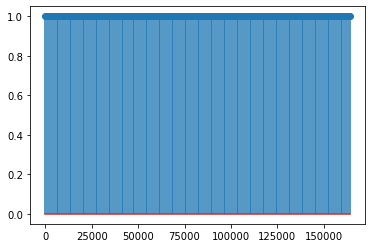

In [308]:
plt.stem(arduino_ttl, np.ones(arduino_ttl.shape))

In [309]:
len(arduino_ttl)

165

In [310]:
np.diff(arduino_ttl)

array([1000, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1002,
       1000, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1000,
       1002, 1000, 1001, 1000, 1002, 1000, 1001, 1001, 1001, 1000, 1000,
       1002, 1000, 1001, 1000, 1002, 1000, 1001, 1000, 1002, 1000, 1000,
       1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1000,
       1001, 1000, 1002, 1000, 1001, 1000, 1002, 1000, 1001, 1001, 1000,
       1001, 1000, 1002, 1000, 1001, 1000, 1002, 1000, 1001, 1000, 1001,
       1001, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1001,
       1001, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1000,
       1002, 1000, 1001, 1000, 1002, 1000, 1001, 1000, 1002, 1000, 1000,
       1002, 1000, 1001, 1000, 1002, 1000, 1001, 1000, 1002, 1000, 1000,
       1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1000,
       1001, 1001, 1001, 1000, 1001, 1001, 1001, 1000, 1001, 1001, 1000,
       1001, 1000, 1002, 1000, 1001, 1000, 1002, 10

In [311]:
np.diff(motu_ttl)

array([ 191984,  191992,  191980,  191988,  191983,  191988,  191989,
        191985,  191992,  191984,  191985,  191985,  191990,  191985,
        191989,  191986,  191987,  191984,  191989,  191987,  191987,
        191986,  191984,  191990,  191987,  191988,  191987,  191985,
        191984,  191991,  191985,  191990,  191985,  191985,  191985,
        191988,  191987,  191986,  191984,  191990,  191987,  191985,
        191989,  191984,  191987,  191989,  191986,  191987,  191987,
        191987,  191986,  191987,  191984,  191986,  191991,  191988,
        191985,  191986,  191988,  191986,  191987,  191986,  191986,
        191988,  191986,  191985,  191990,  191985,  191990,  191984,
        191985,  191992,  191984,  191986,  191988,  191987,  191983,
        191989,  191987,  191984,  191992,  191984,  191986,  191987,
        191987,  191985,  191990,  191985,  191988,  191986,  191987,
        191984,  191988,  191988,  191987,  191988,  191985,  191985,
        191990, 2111

In [312]:
np.median(np.diff(motu_ttl))

191987.0

In [313]:
191987/192000

0.9999322916666666

# Camera Data

In [135]:
for dir in os.listdir(cameras_path):
    for f in os.listdir(os.path.join(cameras_path, dir)):
        fpath = os.path.join(cameras_path,dir,f)
        cname = dir
        print(cname)
        cap = cv2.VideoCapture(fpath)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(total_frames)
        cap.release()
        cv2.destroyAllWindows()


bottom
8250
front
4668
top
8250


# Ephys Data

In [245]:
os.path.join(extracted_ephys_path, '00000_20211101_EVENTS.mat')

'../data/raw/b151/sync_test_211101\\ephys\\logger_13\\extracted_data\\00000_20211101_EVENTS.mat'

In [284]:
f = scipy.io.loadmat(os.path.join(extracted_ephys_path, '00000_20211101_EVENTS.mat'))
ephys_ttl_ts = np.array(f['event_timestamps_usec'])
event_details = f['event_types_and_details']
ephys_ttl_us = []
for i in range(len(event_details)):
    event = event_details[i][0][0]
    if('Digital in rising edge on pin number 4' in event):
        ephys_ttl_us.append(ephys_ttl_ts[i])
ephys_ttl_us = np.array(ephys_ttl_us)

In [287]:
ephys_ttl_us.shape[0]*3

165

# Event timing sync

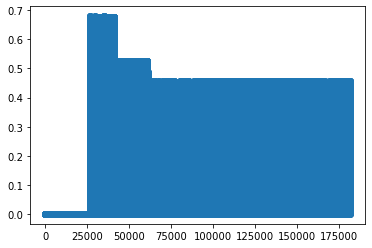

In [213]:
plt.plot(np.arange(len(motu_data[2,motu_first_ttl_index:]))/192, np.abs(motu_data[2,motu_first_ttl_index:]))

In [229]:
state_mapping = {'RESET':0, 'READY':4, 'STIM':3, 'OPEN':2, 'REW':1}
print(arduino_state_ms)
print(state_name)

[26487 40823 60823]
['READY', 'STIM', 'OPEN']


In [372]:
arduino_event_ds = [0]*26487+[4]*(40823-26487)+[3]*(60823-40823)+[2]*int(arduino_ttl[-1]-60823)

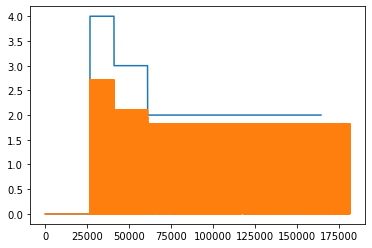

In [235]:
plt.plot([0]*26487+[4]*(40823-26487)+[3]*(60823-40823)+[2]*int(arduino_ttl[-1]-60823))
plt.plot(np.arange(len(motu_data[2,motu_first_ttl_index:]))/192, np.abs(motu_data[2,motu_first_ttl_index:])*4)

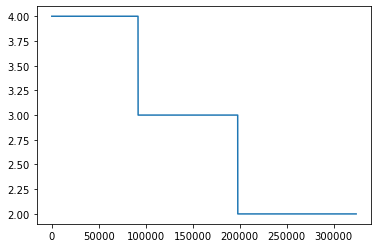

In [217]:
plt.plot(arduino_state_transition_diagram)

In [410]:
motu_event_ds = motu_data[2, motu_first_ttl_index:motu_last_ttl_index][::80] # downsample 80 times
motu_delta_t = (192000/80)/(50) # 48 steps per camera frame (50fps)

In [375]:
arduino_delta_t = 20 # Arduino event ts is at 1000 hz, 20 steps per camera frame (50 fps)

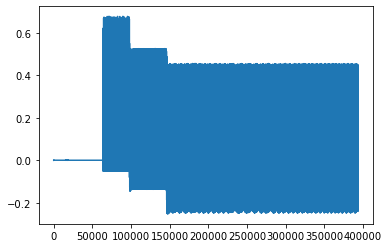

In [411]:
plt.plot(motu_event_ds)

In [463]:
arduino_ttl+65323

array([ 65323,  66323,  67323,  68324,  69325,  70326,  71326,  72327,
        73328,  74329,  75329,  76331,  77331,  78331,  79332,  80333,
        81334,  82334,  83335,  84336,  85337,  86337,  87337,  88339,
        89339,  90340,  91340,  92342,  93342,  94343,  95344,  96345,
        97345,  98345,  99347, 100347, 101348, 102348, 103350, 104350,
       105351, 106351, 107353, 108353, 109353, 110354, 111355, 112356,
       113356, 114357, 115358, 116359, 117359, 118360, 119361, 120361,
       121362, 122362, 123364, 124364, 125365, 126365, 127367, 128367,
       129368, 130369, 131369, 132370, 133370, 134372, 135372, 136373,
       137373, 138375, 139375, 140376, 141376, 142377, 143378, 144378,
       145379, 146380, 147381, 148381, 149382, 150383, 151384, 152384,
       153385, 154386, 155386, 156387, 157388, 158389, 159389, 160390,
       161391, 162392, 163392, 164392, 165394, 166394, 167395, 168395,
       169397, 170397, 171398, 172398, 173400, 174400, 175400, 176402,
      

In [413]:
len(motu_event_ds)

393573

In [414]:
len(arduino_event_ds)

164116

In [487]:
camera_paths = {}
for dir in os.listdir(cameras_path)[:]:
    for f in os.listdir(os.path.join(cameras_path, dir))[:]:
        fpath = os.path.join(cameras_path,dir,f)
        camera_paths[dir] = fpath
camera_paths

{'bottom': '../data/raw/b151/sync_test_211101\\cameras\\bottom\\Basler_acA2040-55um__23584894__20211101_191755157.mp4',
 'front': '../data/raw/b151/sync_test_211101\\cameras\\front\\Basler_acA800-510um__23521662__20211101_191752701.mp4',
 'top': '../data/raw/b151/sync_test_211101\\cameras\\top\\Basler_acA800-510um__23521660__20211101_191753967.mp4'}

In [492]:
for dir in os.listdir(cameras_path)[:1]:
    for f in os.listdir(os.path.join(cameras_path, dir))[:1]:
        fpath = os.path.join(cameras_path,dir,f)
        cname = dir
        print(cname)
        cap_bot = cv2.VideoCapture(camera_paths['bottom'])
        total_frames = int(cap_bot.get(cv2.CAP_PROP_FRAME_COUNT))
        
        cap_top = cv2.VideoCapture(camera_paths['top'])
        
        
        for i in range(4500):
            ret, frame_bot = cap_bot.read()
            ret, frame_top = cap_top.read()
            if(i%10 == 0):
                #fig, axs = plt.subplots(2,2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[5,1]})
                fig = plt.figure(figsize=(8, 4))
                ax1 = plt.subplot(3,3,3)
                ax2 = plt.subplot(3,3,6,sharex=ax1)
                ax3 = plt.subplot(3,3,9)
                #ax4 = plt.subplot(2,3,6)
                ax5 = plt.subplot(1,3,1)
                ax6 = plt.subplot(1,3,2)

                ax5.imshow(frame_bot)
                ax5.axis('off')
                
                ax6.imshow(frame_top)
                ax6.axis('off')

                ax1.plot(np.arange(len(motu_event_ds))/2.4, motu_event_ds)
                ax1.axis('off')
                ax1.axvline(i*motu_delta_t/2.4, -1,1, color='red')


                ax2.plot(np.arange(len(arduino_event_ds)), arduino_event_ds)
                ax2.axvline(i*arduino_delta_t, -1,5, color='red')
                ax2.axis('off')

                #ax3.text(100,100,'sdfs')
                ax3.text(0.5, 0.5, 'Camera Frame: {}'.format(i+1), horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize='large')
                ax3.axis('off')
                plt.tight_layout()
                #plt.show()
                
            
                plt.savefig(folder + "/file%04d.png" % int(i/10), dpi=100)
                #plt.show()
                plt.close(fig)
        
        cap.release()
        cv2.destroyAllWindows()
            #break

bottom


In [479]:
folder = './test'
subprocess.call([
    'ffmpeg', '-framerate', '5', '-i', '{}/file%02d.png'.format(folder), '-r', '30', '-pix_fmt', 'yuv420p',
    'video_name.mp4'
])
        #for file_name in glob.glob("{}/*.png".format(folder)):
        #    os.remove(file_name)

0

In [464]:
28*50

1400

In [465]:
1400*motu_delta_t

67200.0

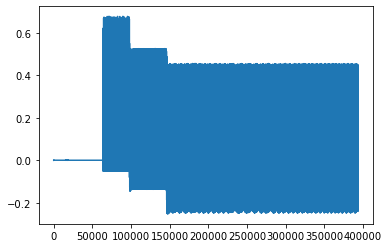

In [474]:
plt.plot(motu_event_ds)

In [467]:
1400*arduino_delta_t

28000

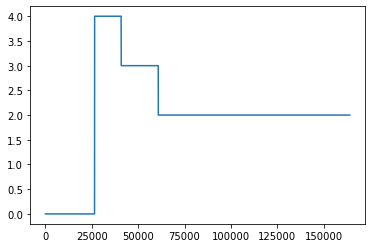

In [475]:
plt.plot(arduino_event_ds)